In [1]:
#importing necessary libraries
import os
import gzip
import shutil
import json

import pandas as pd
from pandas import json_normalize

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns


#prereq step for primary data unizpping
filenames = os.listdir('data/')
for filename in filenames:
    if filename.endswith('.gz'):
        with gzip.open(filename, 'rb') as f_in:
            with open(filename[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
                print(f'{filename} unzipped')
                os.remove(filename)
                print(f'{filename} removed')
    else:
        print(f'{filename} is not a gz file')


users.json is not a gz file
receipts.json is not a gz file
brands.json is not a gz file


### Note : In this notebook, I will present a step by step guide to identify some common data quality concerns for given datasets and summarize it at the end of document.

### Step 1 : Generates 4 data tables based on our data model 
1.  brand\_table
2.  user\_table
3.  receipt\_table
4.  item\_table (extracted from "_rewardsReceiptItemList_" column)

In [2]:
def parse_json(filename: str):
    "Function to parse json files and return a pandas dataframe"

    with open(filename) as f:
        lines = f.read()
    if 'users' in filename:
        # remove the first and last line of the file of the "users.json" file which consists of invalid data
        lines = lines.splitlines()[1:-1]

    else:
        lines = lines.splitlines()

    df_tmp = pd.DataFrame(lines)
    df_tmp.columns = ['json_data']
    df_tmp['json_data'].apply(json.loads)
    ret_json = pd.json_normalize(df_tmp['json_data'].apply(json.loads))

    return ret_json


brand_table= parse_json('data/brands.json')
receipt_table= parse_json('data/receipts.json')
user_table= parse_json('data/users.json')

item_table = receipt_table[['_id.$oid', 'rewardsReceiptItemList']]
item_table = item_table.rename(columns={'_id.$oid': 'receipt_id'})
item_table = item_table.explode('rewardsReceiptItemList')

expanded_receipts = json_normalize(item_table['rewardsReceiptItemList'])
item_table = pd.concat([ item_table.reset_index()['receipt_id'],expanded_receipts,], axis=1)



### Step 2 : Null Value Check

In this step, we will check for null values in the datasets. The findings from this step are summarized as follows:

1.  The user table has the least amount of missing data, with _lastlogin_ column having only 12% of null values, which is within acceptable standards.
2.  The brand-table has significant missing columns, with _categorycode_ and _topbrand_ columns having more than 50% null values.
3.  Receipts table has 9 data fields with more than 40% missing records. Some columns could be of concern such as _purchasedate_/_finisheddate_ or bonus points earned which would be significant in user behavior analytics.
4.  _Item_ table is highly sparse, with 77% of the fields have more than 30% missing values.

Missing values by percentage for Users:


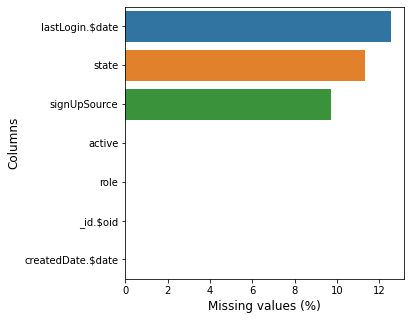

In [3]:
def null_value_check(input_df: pd.DataFrame,name:str=None,fig_width=5,fig_height = 5, orient=None):
    ''' This function returns a bar plot for null values, ranked by percentage of missing values.
    '''
    
    missing_data = input_df.isnull().sum()
    missing_data = missing_data[missing_data >= 0]
    missing_data = (missing_data / len(input_df)) * 100
    print(f'Missing values by percentage for {name}:')
    missing_df =  missing_data.sort_values(ascending=False)
    if not orient:
        plt.figure(figsize=(fig_width, fig_height))
        fig =  sns.barplot(x=missing_df.index, y=missing_df)
        #horizontal bar plot in sns
        fig.set_xticklabels(fig.get_xticklabels(), rotation=70)

        fig.set_ylabel('Missing values (%)', fontsize=12)
        fig.set_xlabel('Columns', fontsize=12)

    if orient == 'h':
        plt.figure(figsize=(fig_width,fig_height))
        fig =  sns.barplot(y=missing_df.index, x=missing_df)
        #horizontal bar plot in sns
        fig.set_ylabel('Columns', fontsize=12)
        fig.set_xlabel('Missing values (%)', fontsize=12)

    return 

null_value_check(user_table, "Users",orient='h')

Missing values by percentage for brands:


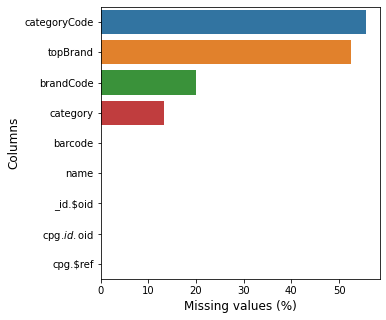

In [4]:
null_value_check(brand_table, "brands",orient='h')

Missing values by percentage for receipts:


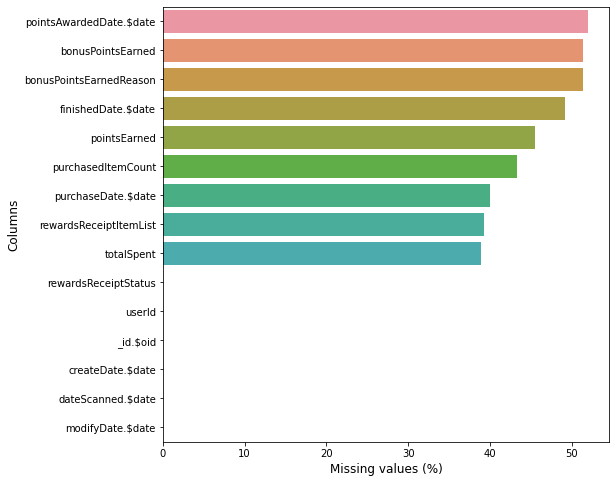

In [5]:
null_value_check(receipt_table, "receipts", fig_width=8,fig_height=8, orient='h')

Missing values by percentage for items:


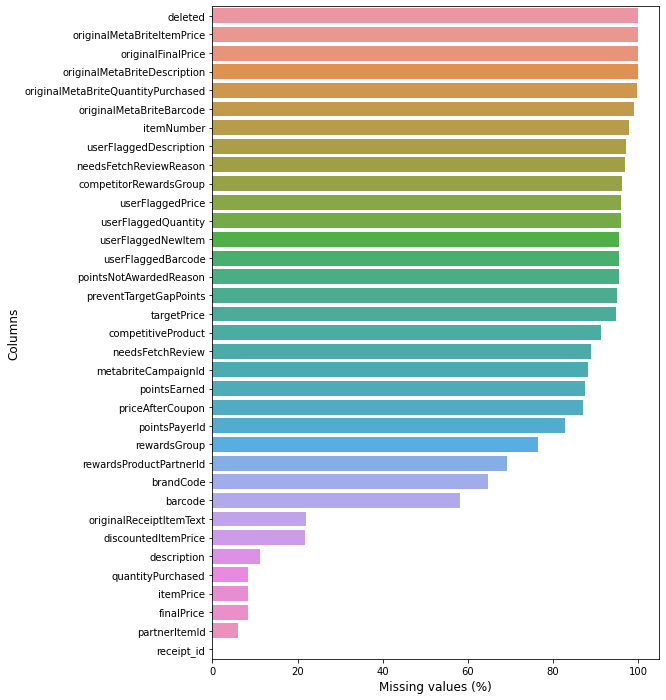

In [6]:
null_value_check(item_table, "items",fig_width=8,fig_height=12,orient='h')

### Step 3 : Data Duplication Check
In this step, we will primarily check for duplicate records across all data sources. The findings from this step are summarized as follows:

1.  User Table has 282 duplicate rows corresponding to 70 users having the same _id_, _active status_, and _creation date_. This could possibly point to a situation where the data logic for updating the "active" status or updating the user-id has failed to operate properly.
2.  For the brand table, there is data duplicaton based on _category_, _categoryCode_, _name, and cpg-id_ fields, resulting in data redundancy. So we need to logically evaluate the requirements for these data fields to remove redundant information or possibly combine multiple fields to get accurate data fields.

#### Step 3.1 : Duplicate user entries 


In [7]:
print(f'Total Duplicate Rows in Users Data : {user_table.duplicated().sum()}')
user_table[user_table.duplicated(subset=['active','role','_id.$oid','createdDate.$date','lastLogin.$date'])].head()


Total Duplicate Rows in Users Data : 282


,active,role,signUpSource,state,_id.$oid,createdDate.$date,lastLogin.$date
1,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
3,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
4,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
7,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12
9,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,1609687444800,1.609688e+12


Text(0.5, 1.0, 'Duplicate Users vs Total Users')

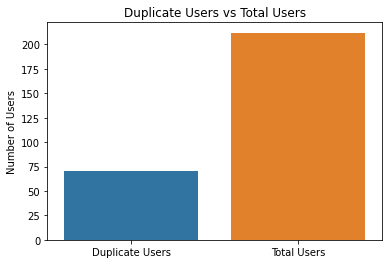

In [8]:
# sns.barplot(user_table[user_table.duplicated()]['_id.$oid'].nunique(), user_table['_id.$oid'].nunique())
sns.barplot(x=['Duplicate Users', 'Total Users'], y=[user_table[user_table.duplicated()]['_id.$oid'].nunique(), user_table['_id.$oid'].nunique()])
plt.ylabel('Number of Users')
plt.title('Duplicate Users vs Total Users')

#### Step 3.2 : Duplicate Brand


In [9]:
brand_table[brand_table.duplicated(subset=['category','categoryCode','name','cpg.$id.$oid'], keep=False)].sort_values(by=['category','categoryCode'])

,barcode,category,categoryCode,name,topBrand,_id.$oid,cpg.$id.$oid,cpg.$ref,brandCode
126,511111104698,Baby,NaN,Pull-Ups,False,5bd201a990fa074576779a19,550b2565e4b001d5e9e4146f,Cogs,PULL UPS
978,511111312949,Baby,NaN,Pull-Ups,True,5db3288aee7f2d6de4248977,550b2565e4b001d5e9e4146f,Cogs,PULLUPS
64,511111805854,Health & Wellness,NaN,ONE A DAY® WOMENS,False,5da609991dda2c3e1416ae90,53e10d6368abd3c7065097cc,Cogs,511111805854
339,511111914051,Health & Wellness,NaN,ONE A DAY® WOMENS,NaN,5e5ff265ee7f2d0b35b2a18f,53e10d6368abd3c7065097cc,Cogs,ONE A DAY® WOMENS
574,511111605546,Snacks,NaN,Baken-Ets,NaN,5d9d08d1a60b87376833e348,5332f5fbe4b03c9a25efd0ba,Cogs,BAKEN ETS
848,511111701781,Snacks,NaN,Baken-Ets,True,585a961fe4b03e62d1ce0e76,5332f5fbe4b03c9a25efd0ba,Cogs,BAKEN-ETS


Table : Duplicate entries with same category, categoryCode, name and brand name

In [10]:
brand_table[brand_table.duplicated(subset=['category','categoryCode','name'], keep=False)].sort_values(by=['category','categoryCode'])


,barcode,category,categoryCode,name,topBrand,_id.$oid,cpg.$id.$oid,cpg.$ref,brandCode
126,511111104698,Baby,NaN,Pull-Ups,False,5bd201a990fa074576779a19,550b2565e4b001d5e9e4146f,Cogs,PULL UPS
978,511111312949,Baby,NaN,Pull-Ups,True,5db3288aee7f2d6de4248977,550b2565e4b001d5e9e4146f,Cogs,PULLUPS
477,511111304616,Beverages,NaN,V8 Hydrate,NaN,5bcdfc5a965c7d66d92731e9,53e10d6368abd3c7065097cc,Cogs,NaN
1025,511111804604,Beverages,NaN,V8 Hydrate,False,5bcdfc5990fa074576779a15,5a734034e4b0d58f376be874,Cogs,V8 HYDRATE
1081,511111206330,Breakfast & Cereal,NaN,Dippin Dots® Cereal,NaN,5dc2d9d4a60b873d6b0666d2,5332f5f3e4b03c9a25efd0ae,Cogs,DIPPIN DOTS
1163,511111706328,Breakfast & Cereal,NaN,Dippin Dots® Cereal,NaN,5dc1fca91dda2c0ad7da64ae,53e10d6368abd3c7065097cc,Cogs,DIPPIN DOTS CEREAL
64,511111805854,Health & Wellness,NaN,ONE A DAY® WOMENS,False,5da609991dda2c3e1416ae90,53e10d6368abd3c7065097cc,Cogs,511111805854
339,511111914051,Health & Wellness,NaN,ONE A DAY® WOMENS,NaN,5e5ff265ee7f2d0b35b2a18f,53e10d6368abd3c7065097cc,Cogs,ONE A DAY® WOMENS
574,511111605546,Snacks,NaN,Baken-Ets,NaN,5d9d08d1a60b87376833e348,5332f5fbe4b03c9a25efd0ba,Cogs,BAKEN ETS
848,511111701781,Snacks,NaN,Baken-Ets,True,585a961fe4b03e62d1ce0e76,5332f5fbe4b03c9a25efd0ba,Cogs,BAKEN-ETS


Table : Duplicate entries with same category, categoryCode, and brand name

In [11]:
receipt_table[receipt_table.duplicated(subset=['_id.$oid',], keep=False)]

,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,_id.$oid,createDate.$date,dateScanned.$date,finishedDate.$date,modifyDate.$date,pointsAwardedDate.$date,purchaseDate.$date


All the receipt id's are unique - No Duplicates found

### Step 4 : Data Consistency
This section is primarily aimed at finding out data discrepancies that needs to be corrected for accurate analytics, such as incomaptible fields, invalid product numbers etc. The findings from this step are summarized as follows:

1.  For _receipt\_item_ table, there are 6 different barcodes that have '**ITEM NOT FOUND'** descriptions. The criteria for these descriptions and the expectations for corresponding reports regarding these barcodes needs to be properly specified.
2.  There are Receipts with _rewardsReceiptStatus_ marked as "**REJECTED**" but having _pointsEarned_ greater than 0. This could point towards an issue in application logic while populating the _pointsEarned_ field. If this is by design, it should be properly documented such that BI applications integrate the logic to handle these cases for accurate reporting. <br>

3.  Receipt Table has 117 unique users, not present in User Table, which accounts for nearly **30% of transcation amount** by _totalSpent_. This needs to resolved as it negatively affects user segmentation analytics.

#### Step 4.1 : "ITEM NOT FOUND" Descriptions
This will identify receipt entries with "ITEM NOT FOUND" in the description, which might indicate issues with barcode scanning or product data lookups. There are 6 different barcode's that don't have accurate descriptions. This needs to be highlighted.


In [12]:
print(item_table[item_table.description == 'ITEM NOT FOUND'].barcode.unique())

['4011' '686924155783' '22' '686924291290' '792851356565' '5000111047524']


Text(0.5, 1.0, "Total Spent vs Total Spent on 'ItemsNotFound' ")

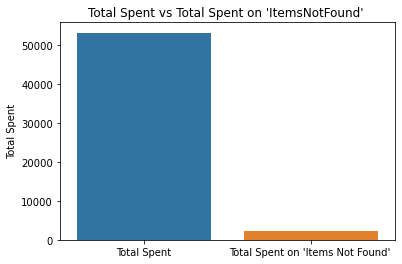

In [13]:
sns.barplot(x=['Total Spent', "Total Spent on 'Items Not Found' "], y=[receipt_table.totalSpent.astype(float).sum(), receipt_table[receipt_table["_id.$oid"].isin(item_table[item_table.description == 'ITEM NOT FOUND'].receipt_id.unique())].totalSpent.astype(float).sum()])
plt.ylabel('Total Spent')
plt.title("Total Spent vs Total Spent on 'ItemsNotFound' ")


#### Step 4.2 : "REJECTED" Receipts with pointsEarned > 0
Receipts with rewardsReceiptStatus marked as "REJECTED" but having pointsEarned greater than 0. Clarification is needed on how these values should be handled while analyzing rewards data.


In [14]:
receipt_table.pointsEarned = receipt_table.pointsEarned.astype(float)
receipt_table[(receipt_table.rewardsReceiptStatus == 'REJECTED') & (receipt_table.pointsEarned > 0)].head()


,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,_id.$oid,createDate.$date,dateScanned.$date,finishedDate.$date,modifyDate.$date,pointsAwardedDate.$date,purchaseDate.$date
2,5.0,All-receipts receipt bonus,5.0,1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b,5ff1e1f10a720f052300057a,1609687537000,1609687537000,NaN,1609687542000,NaN,1.609632e+12
13,750.0,"Receipt number 1 completed, bonus point schedu...",750.0,11.0,"[{'barcode': '075925306254', 'competitiveProdu...",REJECTED,1.00,5f9c74f7c88c1415cbddb839,5f9c74f70a7214ad07000037,1604089079000,1604089079000,NaN,1609687494000,1.604089e+12,1.604003e+12
62,750.0,"Receipt number 1 completed, bonus point schedu...",750.0,2.0,[{'description': 'mueller austria hypergrind p...,REJECTED,34.96,5fbc35711d967d1222cbfefc,5ff4a4ca0a7214ada10005d0,1609868490000,1609868490000,NaN,1609868492000,NaN,1.599955e+12
203,5.0,All-receipts receipt bonus,5.0,1.0,"[{'barcode': '4011', 'finalPrice': '24.00', 'i...",REJECTED,10.00,5ffc9d9cb3348b11c933893f,5ffc9d9c0a7214adca00004b,1610390940000,1610390940000,NaN,1610390945000,NaN,1.610323e+12
207,5.0,All-receipts receipt bonus,5.0,1.0,"[{'barcode': '4011', 'finalPrice': '22.00', 'i...",REJECTED,10.00,5ffcb4b8b3348b11c9338ae1,5ffcb4b80a7214ad4e00000d,1610396856000,1610396856000,NaN,1610396861000,NaN,1.610323e+12


Text(0.5, 1.0, 'Total Points Earned vs Total Points Earned on Rejected Receipts ')

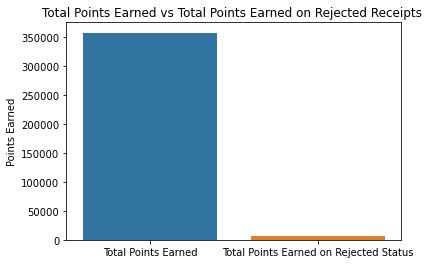

In [15]:
sns.barplot(x=['Total Points Earned', "Total Points Earned on Rejected Status"], y=[receipt_table.pointsEarned.astype(float).sum(), receipt_table[receipt_table.rewardsReceiptStatus=="REJECTED"].pointsEarned.astype(float).sum()])
plt.ylabel('Points Earned')
plt.title("Total Points Earned vs Total Points Earned on Rejected Receipts ")


#### Step 4.3 : User_id's from receipt data that are not present in User Table

Text(0.5, 1.0, 'Users from receipt table not present in user table')

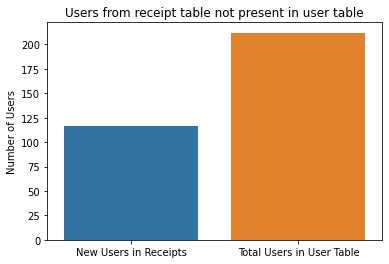

In [16]:
#list of user id from receipt table which are not present in user table
left_out_users = len(receipt_table[~receipt_table.userId.isin(user_table['_id.$oid'])].userId.unique())

sns.barplot(x=['New Users in Receipts', 'Total Users in User Table'], y=[left_out_users, user_table['_id.$oid'].nunique()])
plt.ylabel('Number of Users')
plt.title('Users from receipt table not present in user table')

Text(0.5, 1.0, 'Total Spent vs Total Spent by Missing Users')

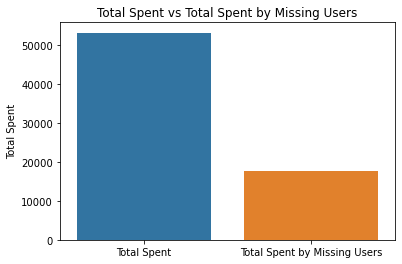

In [17]:
sns.barplot(x=['Total Spent', 'Total Spent by Missing Users'], y=[receipt_table.totalSpent.astype(float).sum(),receipt_table[~receipt_table.userId.isin(user_table['_id.$oid'])].totalSpent.astype(float).sum()])
plt.ylabel('Total Spent')
plt.title('Total Spent vs Total Spent by Missing Users')


#### Step 4.4 : Inconsistency between userFlaggedBarcode and originalMetaBriteBarcode fields
Proper documentation is needed in order to understand the discrepancies between userFlaggedBarcode, barcode and originalMetaBriteBarcode fields.

In [18]:
item_table[(item_table.barcode!= item_table.originalMetaBriteBarcode) & (~item_table.originalMetaBriteBarcode.isna())][['userFlaggedBarcode','originalMetaBriteBarcode','barcode']].head()

,userFlaggedBarcode,originalMetaBriteBarcode,barcode
7,4011,028400642255,4011
68,079400066619,080878042197,079400066619
175,079400066619,080878042197,079400066619
374,079400066619,080878042197,079400066619
392,4011,028400642255,4011


Once these issues are resolved, we can proceed with data transformation and even use more advanced statistical and machine learning methods to identify data quality issues.